# Shape reconstruction

## Overview
One goal with Differentiable Rendering is the reconstruction of geometry.
In this tutorial we will implement one way to reconstruct the shape of an object from a single image.

The object pose estimation tutorial showed how to infer the pose of an object
using differentiable rendering.
In that tutorial the issue of differentiating with respect to the position of
discontinuities was addressed using reparameterization.
However, applying this approach directly to shape reconstruction yields incorrect results.
The problem is that gradients from discontinuities are stronger at the silhouette of the object.
This results in large gradients at the outermost vertices.
When optimizing, these vertices are then moved further than their counterparts inside the silhouette.
After a number of optimization steps this leads to self intersections, which
makes the mesh practically unusable.
To address these problems, a number of approaches have been invented.
One of them was described in the paper "Large Steps in Inverse Rendering of Geometry" 
<cite data-cite = "Nicolet2021Large"> Nicolet et al. (2021)</cite>.
We will use a reparameterized coordinates to represent the vertex coordinates
in a way that allows for smooth inference of the shape.
<!-- TODO: You will learn... -->

## Setup
As always, we need to import `drjit` and `mitsuba` and set the CUDA AD-aware variant.

In [5]:
import drjit as dr
import mitsuba as mi

mi.set_variant("cuda_ad_rgb")

In addition, we need `trimesh` for creating an icosphere mesh and `NumPy` for
converting between the array representation.
The `largesteps` package is also a necessary requirement though we are going to
import it in the helper functions to avoid name conflicts.
To visualize the results we also need the `matplotlib` library.
Finally, `PyTorch` is necessary to perform the matrix multiplications in the largesteps package.

In [6]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt
import torch

## Helper functions for largesteps

Since `largesteps` uses PyTorch tensors we need to convert between PyTorch and Mitsuba.
To make this easier we define some helper functions which can be called using Mitsuba variables.
First, we need to calculate a parametrization matrix. It is calculated using
the Laplacian of the mesh.
The `largesteps` package provides a function to calculate this matrix. 
However, it uses PyTorch tensors to represent the faces and vertex positions of the mesh.
Since we use this matrix as a constant we do not need gradient backpropagation
and can use the `.torch()` function to convert between Mitsuba tensors and PyTorch tensors.

In [7]:
def compute_matrix(positions: mi.Float, faces: mi.UInt, lambda_: float) -> torch.Tensor:
    positions = mi.TensorXf(positions, shape=(len(positions) // 3, 3))
    faces = mi.TensorXi(faces, shape=(len(faces) // 3, 3))

    positions = positions.torch()
    faces = faces.torch()

    from largesteps.geometry import compute_matrix

    M = compute_matrix(positions, faces, lambda_)

    return M

Because Mitsuba uses flattened arrays for storing the positions and faces of a
mesh we can construct two Nx3 tensors by simply specifying the shape and
passing the variables to them.

We use latent variables to represent the reparameterized coordinates.
To convert from and to this representation we can use the `to_differential` and
`from_differential` functions provided by `largesteps`.
In order to make it easier to work with these functions we can again write two
helper functions.
Since we need gradients to backpropagate back to the reparameterized
coordinates we need to use the `wrap_ad` decorator from `drjit`.
However, as the parametrization matrix is a constant we can pass it directly to
the function from `largesteps` by using pythons variable capturing.
We denote the actual vertex positions with `v` and the reparameterized coordinates with `u`.

In [8]:
def to_differential(M: torch.Tensor, v: mi.Float) -> mi.Float:
    v = mi.TensorXf(v, shape=(len(v) // 3, 3))

    @dr.wrap_ad(source="drjit", target="torch")
    def to_differential_internal(v: torch.Tensor):
        from largesteps.parameterize import to_differential

        return to_differential(M, v)

    return to_differential_internal(v).array


def from_differential(M: torch.Tensor, u: mi.Float, method="Cholesky") -> mi.Float:
    u = mi.TensorXf(u, shape=(len(u) // 3, 3))

    @dr.wrap_ad(source="drjit", target="torch")
    def to_differential_internal(u: torch.Tensor):
        from largesteps.parameterize import from_differential

        return from_differential(M, u, method)

    return to_differential_internal(u).array

## Loading reference image

Now let's load the reference image and display it. We need to load an HDR image for the inference to work properly.
In this case we can use a single reference image as the scene is relatively
simple. However, more reference images might be necessary if the geometry is
more complex, or we try to additionally reconstruct material properties.

(-0.5, 1023.5, 1023.5, -0.5)

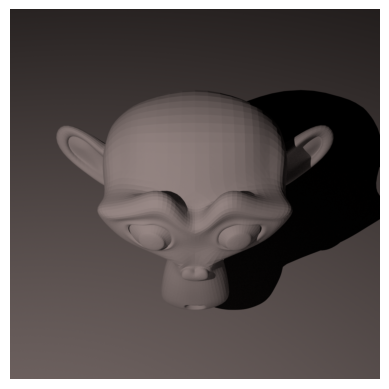

In [70]:
ref = mi.TensorXf(mi.Bitmap("../scenes/references/suzanne.exr"))

plt.imshow(mi.util.convert_to_bitmap(ref))
plt.axis("off")

## Initialization

In order to perform shape reconstruction, an initial scene is required.
We are using the same scene from which the reference image is rendered but with
an icosphere as the mesh prior.
This could either be loaded from a file or dynamically generated.
In this case we use `trimesh`, a geometry processing library to generate the
icosphere. To convert the `trimesh` mesh into a Mitsuba mesh we can define
another helper function.

In [ ]:
def trimesh2mitsuba(mesh: trimesh.Trimesh) -> mi.Mesh:
    positions: np.ndarray = np.array(mesh.vertices)
    indices: np.ndarray = np.array(mesh.faces)
    mesh = mi.Mesh(
        "trimesh",
        vertex_count=positions.shape[0],
        face_count=indices.shape[0],
        has_vertex_normals=False,
        has_vertex_texcoords=False,
    )

    params = mi.traverse(mesh)
    params["vertex_positions"] = dr.ravel(mi.Point3f(positions))
    params["faces"] = dr.ravel(mi.Vector3u(indices))
    params.update()
    return mesh

More Information about how to construct a mesh procedurally can be found in the "Mesh I/O and manipulation" Tutorial.
Now we can set up the scene for reconstruction.
We need to use the `prb_reparam` integrator as we are differentiating with respect to the position of discontinuities.
For the mesh we are using an icosphere with 4 subdivision and a radius of 0.5.


In [ ]:
scene = mi.load_dict({
    "type": "scene",
    "integrator": {
        "type": "prb_reparam",
    },
    "sensor": {
        "type": "perspective",
        "to_world": mi.ScalarTransform4f.look_at(
            origin=(0, 2, 2), target=(0, 0, 0), up=(0, 0, 1)
        ),
        "film": {
            "type": "hdrfilm",
            "width": 1024,
            "height": 1024,
            "sample_border": True,
        },
    },
    "floor": {
        "type": "rectangle",
        "to_world": mi.ScalarTransform4f.translate([0, 0, -1]).scale(10),
    },
    "light": {
        "type": "point",
        "position": [1, 2, 2],
        "intensity": {
            "type": "spectrum",
            "value": 10.0,
        },
    },
    "mesh": trimesh2mitsuba(
        trimesh.creation.icosphere(subdivisions=4, radius=0.5)
    )
})

Let's render the scene with the initial mesh and display it.

(-0.5, 1023.5, 1023.5, -0.5)

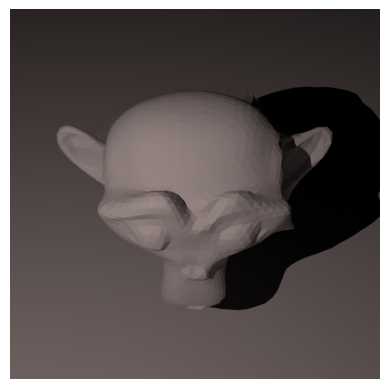

In [72]:
initial = mi.render(scene, spp = 128)

plt.imshow(mi.util.convert_to_bitmap(initial))
plt.axis("off")

## Optimization

As always we first need to extract the parameters of the scene with the `mi.traverse` function.

In [ ]:
params = mi.traverse(scene)

print(params)

We need to extract the positions and faces from the parameters.
In order to see what parameters are available we can optionally print the parameters.
Then, we can compute the parametrization matrix with our helper function we defined above.
As these helper functions handle the conversion to tensors of shape Nx3 we
can pass the flattened positions and faces directly to them.

In [ ]:
v = params["mesh.vertex_positions"]
faces = params["mesh.faces"]

M = compute_matrix(v, faces, lambda_=10)
u = to_differential(M, v)

To perform the position update we can use the Adam optimizer and give it a learning rate of $0.01$.
Since we are using a latent variable to represent our reparameterized
coordinates we can add `u` to the optimizer with a custom key string.

In [ ]:
opt = mi.ad.Adam(lr=0.01)
opt["u"] = u

Finally, in the optimization loop we need to calculate the vertex position `v`
from the reparameterized coordinates `u` using the `from_differential` function and the parametrization matrix `M`.
At every step we can write the output of the renderer to a file, which allows us to show the progress visually.

In [ ]:
loss_hist = []
for i in range(200):
    print(f"Iteration {i}:")
    u = opt["u"]
    v = from_differential(M, u)
    params["mesh.vertex_positions"] = v
    params.update()

    img = mi.render(scene, params, spp=1, seed = i)

    mi.util.write_bitmap(f"out/{i}.jpg", img)

    loss = dr.mean(dr.sqr(img - ref))
    print(f"loss={loss[0]}")
    loss_hist.append(loss[0])

    dr.backward(loss)

    opt.step()

Now we can render the scene with the final mesh with more samples.

In [ ]:
final = mi.render(scene, params, spp = 128)

## Visualizing the results

After running the inference for $200$ iterations we can visualize the results.

Text(0.5, 1.0, 'Reference Image')

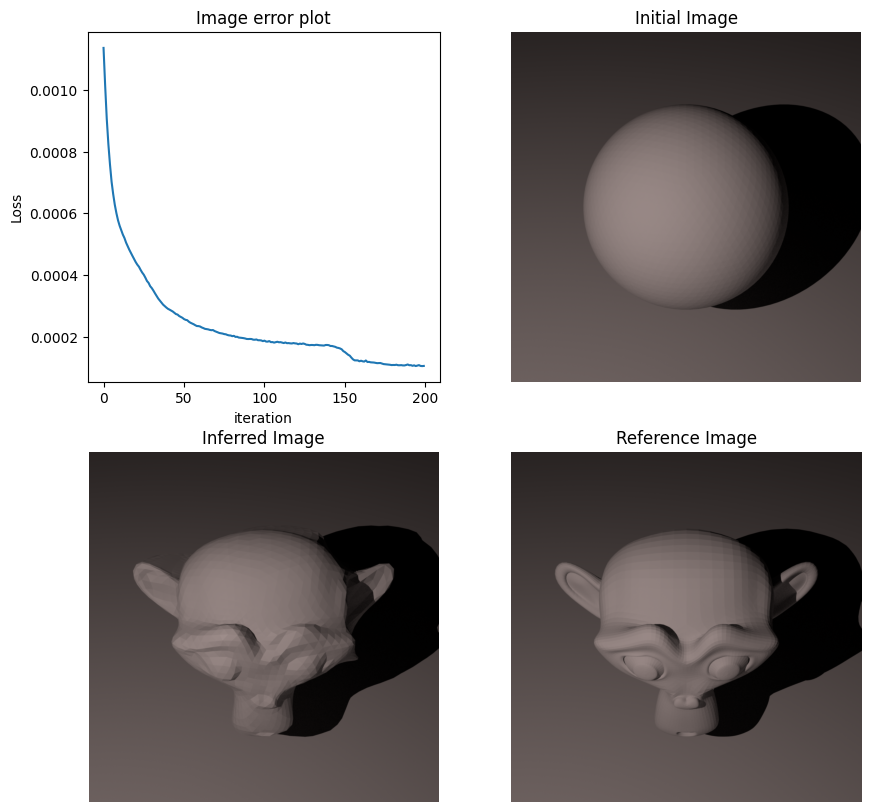

In [71]:
fig, axs = plt.subplots(2, 2, figsize = (10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel("iteration")
axs[0][0].set_ylabel("Loss")
axs[0][0].set_title("Image error plot")

axs[0][1].imshow(mi.util.convert_to_bitmap(initial))
axs[0][1].axis("off")
axs[0][1].set_title("Initial Image")

axs[1][0].imshow(mi.util.convert_to_bitmap(final))
axs[1][0].axis("off")
axs[1][0].set_title("Inferred Image")

axs[1][1].imshow(mi.util.convert_to_bitmap(ref))
axs[1][1].axis("off")
axs[1][1].set_title("Reference Image")

Looking at the loss graph we can sharp step in the error graph around iteration 150, the reason
for which is not directly apparent from the result. 
Another method for visualizing the result of differentiable rendering
pipelines, which gives a little bit more insight is to render a video from the
images rendered in each iteration.
As we wrote the images to files in the optimization loop we can now use
`ffmpeg` to create a video from them.
So that the video is playable in the Firefox browser we can use the following command in the output directory.
`ffmpeg -i %d.jpg -vcodec libx264 -acodec mp2 -pix_fmt yuv420p reparam.mp4`